# セットアップ

In [1]:
# 使用モジュールをインポート
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# データの前処理

## データの取得

In [2]:
# ファイルを取得して、パスを通す
Japan = "/content/drive/MyDrive/lab/論文発表/男女"
Man_dir = os.path.join(Japan, "Japanese_Man")
Woman_dir = os.path.join(Japan, "Japanese_Woman")

**男女**

|__ **Japanese_Man**: [img00001.jpg, img00002.jpg, img00003.jpg ...]

|__ **Japanese_Woman**: [img24001.jpg, img24002.jpg, img24003 ...]

In [3]:
# バッチサイズ、画像サイズの決定
BATCH_SIZE = 64
IMG_SIZE = (160, 160)

In [4]:
# ディレクトリの確認
Man_dir

'/content/drive/MyDrive/lab/論文発表/男女/Japanese_Man'

In [5]:
# ディレクトリの中身の確認
!ls /content/drive/MyDrive/lab/論文発表/男女/Japan_Man

img00017.jpg  img06332.jpg  img18390.jpg  img20139.jpg	img24416.jpg
img00039.jpg  img07276.jpg  img18398.jpg  img20151.jpg	img24442.jpg
img00141.jpg  img07466.jpg  img18402.jpg  img20174.jpg	img24454.jpg
img00157.jpg  img07555.jpg  img18456.jpg  img20192.jpg	img24462.jpg
img00172.jpg  img07732.jpg  img18510.jpg  img20197.jpg	img24488.jpg
img00185.jpg  img07831.jpg  img18522.jpg  img20217.jpg	img24492.jpg
img00199.jpg  img07929.jpg  img18528.jpg  img20220.jpg	img24498.jpg
img00205.jpg  img08652.jpg  img18531.jpg  img20221.jpg	img24499.jpg
img00210.jpg  img08656.jpg  img18536.jpg  img20228.jpg	img24500.jpg
img00211.jpg  img08668.jpg  img18543.jpg  img20256.jpg	img24504.jpg
img00213.jpg  img08690.jpg  img18594.jpg  img20269.jpg	img24563.jpg
img00220.jpg  img08748.jpg  img18611.jpg  img20282.jpg	img24603.jpg
img00221.jpg  img08887.jpg  img18612.jpg  img20301.jpg	img24620.jpg
img00222.jpg  img09095.jpg  img18621.jpg  img20320.jpg	img24623.jpg
img00223.jpg  img09321.jpg  img18638.jpg  img203

In [6]:
# tf.data.Datasetの作成
train_dataset = image_dataset_from_directory(Japan, shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 1514 files belonging to 2 classes.


In [7]:
# クラス名を与える
class_names = train_dataset.class_names

## データを分割する

In [8]:
# train_datasetからテスト・検証用データを作る

# trainのバッチサイズを取得
train_batches = tf.data.experimental.cardinality(train_dataset)

# trainの半分のバッチををvalidationに移す
validation_dataset = train_dataset.take(train_batches // 2)
train_batches = train_dataset.skip(train_batches // 2)

# validation_datasetの20％のバッチをtestに移す
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
val_batches = validation_dataset.skip(val_batches // 5)

In [9]:
# データの送受信を効率化
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [10]:
# データ拡張層
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [11]:
# MobileNetV2に入力できるよう変形する層
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input



In [12]:
# 画像サイズの指定
IMG_SHAPE = IMG_SIZE + (3,)

# ベースモデル取得
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [13]:
# バッチサイズの取得
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(64, 5, 5, 1280)


In [14]:
# ベースモデルの学習を無効化
base_model.trainable = False

In [15]:
# ベースモデルのアーキテクチャ確認
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [16]:
# pooling層
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(64, 1280)


In [17]:
# 2値分類を行う全結合層作成
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(64, 1)


In [18]:
# 層をチェーン化したモデルを作る
inputs = tf.keras.Input(shape=(160, 160, 3))  # 入力
x = data_augmentation(inputs) # データ拡張
x = preprocess_input(x) # データの前処理
x = base_model(x, training=False) #ベースモデル
x = global_average_layer(x) # プーリング層
x = tf.keras.layers.Dropout(0.2)(x) # ドロップアウト
outputs = prediction_layer(x) # 全結合層
model = tf.keras.Model(inputs, outputs) # モデル

In [19]:
# モデルコンパイル
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [20]:
# モデルアーキテクチャ確認
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [21]:
# モデル訓練
initial_epochs = 10
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
24/24 [==============================] - 69s 3s/step - loss: 1.0056 - accuracy: 0.3606 - val_loss: 0.7860 - val_accuracy: 0.3568
Epoch 2/10
24/24 [==============================] - 15s 533ms/step - loss: 0.7202 - accuracy: 0.4868 - val_loss: 0.6567 - val_accuracy: 0.5195
Epoch 3/10
24/24 [==============================] - 15s 534ms/step - loss: 0.6223 - accuracy: 0.6017 - val_loss: 0.5991 - val_accuracy: 0.6497
Epoch 4/10
24/24 [==============================] - 15s 536ms/step - loss: 0.5702 - accuracy: 0.6697 - val_loss: 0.5565 - val_accuracy: 0.7070
Epoch 5/10
24/24 [==============================] - 15s 540ms/step - loss: 0.5296 - accuracy: 0.7133 - val_loss: 0.5156 - val_accuracy: 0.7513
Epoch 6/10
24/24 [==============================] - 15s 532ms/step - loss: 0.5081 - accuracy: 0.7332 - val_loss: 0.4947 - val_accuracy: 0.7786
Epoch 7/10
24/24 [==============================] - 15s 536ms/step - loss: 0.4689 - accuracy: 0.7801 - val_loss: 0.4753 - val_accuracy: 0.8034
Ep

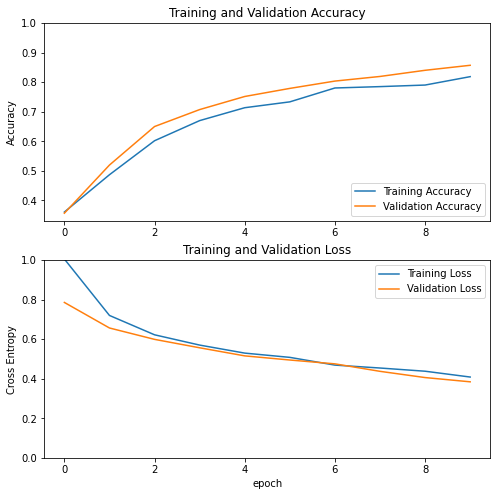

In [22]:
# 学習の様子
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# fine-tuning

In [23]:
# ベースモデルのフリーズ解除
base_model.trainable = True

In [24]:
# ベースモデルにある層の数を確認
print("Number of layers in the base model: ", len(base_model.layers))

# ファインチューニングする層の数を決める（100層）
fine_tune_at = 100

# 100層以外の層はフリーズ
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


In [25]:
# モデルコンパイル
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [26]:
# モデルアーキテクチャ確認
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [27]:
# モデル訓練（fine tuning）
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
24/24 [==============================] - 25s 612ms/step - loss: 0.3144 - accuracy: 0.8580 - val_loss: 0.2291 - val_accuracy: 0.8828
Epoch 11/20
24/24 [==============================] - 16s 566ms/step - loss: 0.2428 - accuracy: 0.8950 - val_loss: 0.1996 - val_accuracy: 0.9284
Epoch 12/20
24/24 [==============================] - 16s 572ms/step - loss: 0.2152 - accuracy: 0.9128 - val_loss: 0.1837 - val_accuracy: 0.9219
Epoch 13/20
24/24 [==============================] - 16s 582ms/step - loss: 0.2142 - accuracy: 0.9095 - val_loss: 0.1625 - val_accuracy: 0.9362
Epoch 14/20
24/24 [==============================] - 16s 571ms/step - loss: 0.2076 - accuracy: 0.9095 - val_loss: 0.1597 - val_accuracy: 0.9193
Epoch 15/20
24/24 [==============================] - 16s 578ms/step - loss: 0.2016 - accuracy: 0.9141 - val_loss: 0.1535 - val_accuracy: 0.9310
Epoch 16/20
24/24 [==============================] - 16s 569ms/step - loss: 0.1846 - accuracy: 0.9280 - val_loss: 0.1543 - val_accuracy:

In [28]:
# fine-tuning後のacc, val_acc, loss, val_loss
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

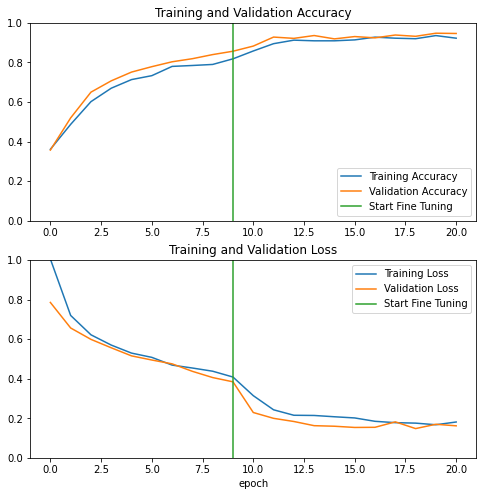

In [29]:
# 学習の様子をプロット
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# モデルの評価

In [30]:
# loss, accuracyを見てみる
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

2/2 [==============================] - 3s 363ms/step - loss: 0.1769 - accuracy: 0.9297
Test accuracy : 0.9296875


Predictions:
 [1 1 0 0 1 1 1 1 1 1 0 0 1 0 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 0
 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 0 1 0 1 1 1 1 0 0 1]
Labels:
 [1 1 0 0 1 1 1 1 1 1 0 0 1 0 1 0 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 0
 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 0 1 0 1 1 1 1 0 0 1]


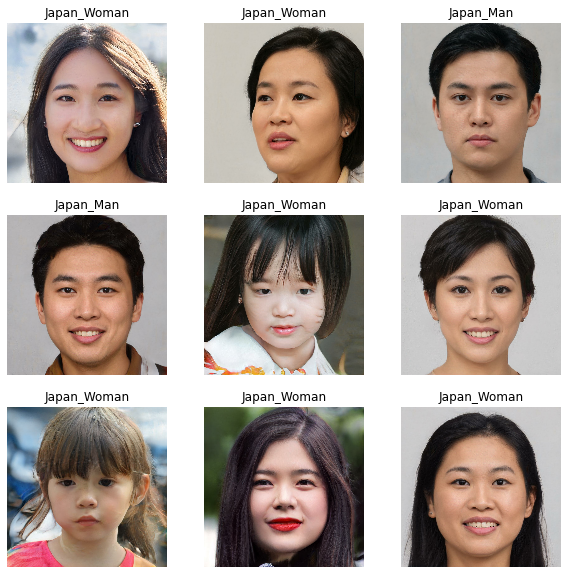

In [31]:
# バッチサイズ取得
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# ロジットをシグモイドに
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

# 結果の表示
print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

# 学習済みモデルの保存

In [34]:
# 保存先のパスを指定する
export_path = "/content/drive/MyDrive/lab/論文発表/{}".format("男女識別")

# モデルの保存
model.save(export_path, save_format='tf')

# 保存先を参照する
export_path

INFO:tensorflow:Assets written to: /content/drive/MyDrive/lab/論文発表/男女識別/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


'/content/drive/MyDrive/lab/論文発表/男女識別'

In [35]:
# 保存したモデルを呼び出す
reloaded = tf.keras.models.load_model(export_path)